Ths script creates the synthetic dataset for both neuron datasets. The first dataset consideres the dead vs alive neurons, while the second dataset tries to differentiate between neighboring live neurons to resolve overlaps.

In [82]:
import h5py as h5
import imageio as io
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from skimage.filters import gaussian
from scipy.stats import expon

In [83]:
number_images      = 1728

In [84]:
data_path          = '../Data/'

In [85]:
density_low        =  60000 # 1/cm²
density_high       = 240000 # 1/cm²
image_size         = 636.4  # µm

In [86]:
image_size_cm      = image_size    / 10000.
image_small        = image_size_cm / 4.

In [87]:
ratio_high_low     = 0.6  # approximate percent of data images seeded with the high density
seeding_viability  = 0.9  # Viability during seeding (estimate)
expected_viability = 0.25 # Viability at time of imaging (estimate)

In [103]:
def make_clumping_positions(n_live_neurons): #live neurons like to clump together. 
    def split_to_group(number,n):
        '''With clumping correlations, we do not want to make 1 big group, but more little pockets of neurons'''
        result=0
        if n==1:
            return [number]
        while result!=number:
            split_chunk=np.random.randint(1,number,n)
            result=np.sum(split_chunk)
        return split_chunk
    
    in_fov=False
    if n_live_neurons==1:
        num_groups=1
    else:
        num_groups=np.random.randint(1,np.min( (5,n_live_neurons)))
    n_chunks=split_to_group(n_live_neurons,num_groups)
    while in_fov==False:
        abs_pos=np.array([0,0])
        for n in n_chunks:
            first_neuron=np.random.rand(1,2)*255
            distances=expon.rvs(loc=8,scale=45,size=(n-1,1))
            angles=np.random.rand(n-1,1)*2*np.pi
            other_neurons_relative=(distances*np.array([np.cos(angles),np.sin(angles)])).reshape(2,n-1).T
            neurons_absolute=np.cumsum(np.vstack((first_neuron,other_neurons_relative)),axis=0)
            abs_pos=np.vstack((abs_pos,neurons_absolute))
        if np.allclose(abs_pos,np.clip(abs_pos,0,255)):
            in_fov=True
    return abs_pos[1:,:] #remove first placeholder position

def gauss_intensity_rot(xx,yy,x0,y0,sigma_x,sigma_y,rot,height):
    gauss = lambda x,s: np.exp(-(x**2/(s**2)))
    new_xx=(xx-x0)*np.cos(rot)+(yy-y0)*np.sin(rot)
    new_yy=(xx-x0)*np.sin(rot)-(yy-y0)*np.cos(rot)
    return gauss(new_xx,sigma_x)*gauss(new_yy,sigma_y)*height+np.random.normal(0.05,0.02,size=np.shape(xx))
def ellipse(xx,yy,x0,y0,ax1,ax2,rot):
    x_,y_ = (xx-x0),(yy-y0)
    c,s=np.cos(rot),np.sin(rot)
    return (x_*c+y_*s)**2/ax1**2+(x_*s-y_*c)**2/ax2**2 < 1
def rotate(seg,ang):
    x=seg[0]*np.cos(ang)-seg[1]*np.sin(ang)
    y=seg[1]*np.cos(ang)+seg[0]*np.sin(ang)
    return np.array([x,y])
def make_axon(tortuousity,n_seg,seg_length):
    segment=np.array([seg_length,0]).reshape(2,1)
    init_angle=np.random.rand()*2*np.pi
    segment=rotate(segment,init_angle)
    next_angles=np.random.normal(0,tortuousity,size=n_seg-1)
    next_segments=rotate(segment,next_angles)
    return np.cumsum(np.hstack((segment,next_segments)),axis=1).astype(int)#add all segments up to make the axon
def live_neuron_oval(xx,yy,x0,y0):
    ab=np.random.randint(36,81) #simialr to a 6x6 or 9x9 area
    ax1=np.random.randint(int(0.7*np.sqrt(ab)),int(1.3*np.sqrt(ab))) #oval range
    ax2=ab/ax1
    rot=np.random.rand()*np.pi #rotate it
    body=ellipse(xx,yy,x0,y0,ax1,ax2,rot)
    if ax1>ax2:
        hinge1=[(x0+ax1)*np.cos(rot),(x0+ax1)*np.sin(rot)]
        hinge2=[(x0-ax1)*np.cos(rot),(x0-ax1)*np.sin(rot)]
    else:
        hinge1=[x0+ax2*np.cos(rot+np.pi/2.),y0+ax2*np.sin(rot+np.pi/2.)]
        hinge2=[x0-ax2*np.cos(rot+np.pi/2.),y0-ax2*np.sin(rot+np.pi/2.)]
    axon_layer=np.zeros((256,256))

    for i in range(np.random.randint(0,4)):
        p=np.random.rand()
        if p>0.5:
            hinge=hinge1
        else:
            hinge=hinge2
        ax,ay=hinge[1],hinge[0]
        axon=make_axon(tortuousity=0.4,n_seg=np.random.randint(15,80),seg_length=1)+np.array([int(ax),int(ay)]).reshape(2,1)
        axon=np.clip(axon,0,255)
        axon_layer[axon[0,:],axon[1,:]]=True
    axon_layer[body]=False #cover the axons with the cell body
    final=np.zeros((256,256,2))
    final[:,:,1]=body
    final[:,:,0]=axon_layer
    return final.astype(bool),ax1,ax2,rot
def put_live_neurons(synthetic_image,count,clumping_bool=False):
    if count!=0:
        if clumping_bool==True:
            centers=make_clumping_positions(count)
        else:
            centers=np.random.rand(count,2)*255
    for i in range(count):
        tmp_a=np.zeros((256,256))
        tmp_b=np.zeros((256,256))
        center=centers[i,:]
        axbody,ax1,ax2,rot=live_neuron_oval(xx,yy,center[0],center[1])
        jitter_x_I=-ax2/3.+2/3.*np.random.rand()*ax2
        jitter_y_I=ax1/3.+2/3.*np.random.rand()*ax1
        sigma_xI=1.2*ax1
        sigma_yI=1.2*ax2
        I=0.7+0.3*np.random.rand()
        intensity=gauss_intensity_rot(xx,yy,center[0]+jitter_x_I,center[1]+jitter_y_I,sigma_xI,sigma_yI,rot,I)# gauss halo coloring

        tmp_a[axbody[:,:,0]]=np.random.normal(.9+0.5*np.random.rand(),0.1,size=(256,256))[axbody[:,:,0]] #axons
        final_intensity=np.max(np.vstack((synthetic[axbody[:,:,1],1],intensity[axbody[:,:,1]])),axis=0)
        tmp_b[axbody[:,:,1]]=final_intensity #bodies
        synthetic[axbody[:,:,1],1]=tmp_b[axbody[:,:,1]]
        synthetic[:,:,0]+=gaussian(tmp_a,sigma=1.2,mode='wrap')
def put_dead_neurons(synthetic,cell_radius,count):
    for i in range(count):
        tmp=np.zeros((256,256))
        center=np.random.randint(255),np.random.randint(255)
        jitter_x_I=-cell_radius/3.+2/3.*np.random.rand()*cell_radius
        jitter_y_I=-cell_radius/3.+2/3.*np.random.rand()*cell_radius
        sigma_xI=0.8*cell_radius
        sigma_yI=0.8*cell_radius
        I=0.7+0.3*np.random.rand()
        intensity=gauss_intensity_rot(xx,yy,center[0]+jitter_x_I,center[1]+jitter_y_I,sigma_xI,sigma_yI,0,I)# gauss halo coloring
        cell_mask=ellipse(xx,yy,center[0],center[1],cell_radius,cell_radius,0)
        if np.max(synthetic[cell_mask,1])<0.5:
            tmp[cell_mask]=intensity[cell_mask]
            synthetic[:,:,2]+=tmp

In [104]:
xx,yy=np.meshgrid(np.arange(256),np.arange(256))

In [105]:
directory = data_path + 'Neuron_Dead_Live/Synthetic_noclump/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [106]:
for i in range(number_images):
    if np.random.random() < ratio_high_low: # high density
        live_count = np.random.poisson(image_small*image_small*density_high/seeding_viability*expected_viability)    
        dead_count = np.random.poisson(image_small*image_small*density_high/seeding_viability*(1-expected_viability))

    else:                        # low density
        live_count = np.random.poisson(image_small*image_small*density_low/seeding_viability*expected_viability)
        dead_count = np.random.poisson(image_small*image_small*density_low/seeding_viability*(1-expected_viability))
    
    name=directory+str(i).zfill(5)+'.png'
    synthetic=np.random.normal(0.15,0.07,size=(256,256,3))
    put_live_neurons(synthetic,live_count,clumping_bool=False)
    put_dead_neurons(synthetic,4.5,dead_count)
    image=(np.clip(synthetic,0,1)*255).astype(np.uint8)
    io.imsave(name,image)
    if i%50==0:
        print i,


0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1550 1600 1650 1700


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


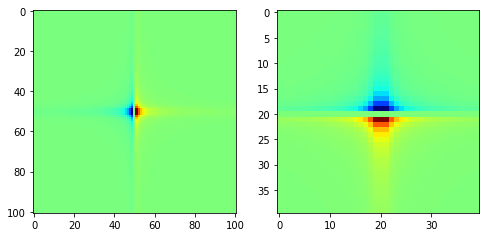

In [107]:
# Create the 1/x masks to decode position
ls            = np.linspace(-50,50,101)
grid_X,grid_Y = np.meshgrid(ls,ls)
grid_R        = (0.75*5/np.abs(grid_X)) * np.sign(grid_X)
grid_R[:,50]  = grid_R[:,51]
grid_R        = np.maximum(np.minimum(grid_R,3),-3)
maskX         = grid_R * np.abs(grid_R.T)
maskX[:,50]   = 0.
maskY         = maskX.T
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(maskX,cmap='jet')
plt.subplot(1,2,2)
a = 20
plt.imshow(maskY[50-a:50+a,50-a:50+a],cmap='jet')
plt.show()

In [130]:
from scipy.signal import convolve2d,fftconvolve
def colored_neurons(clumping_bool=False):
    if np.random.random() < ratio_high_low: # high density
        live_count = np.random.poisson(image_small*image_small*density_high/seeding_viability*expected_viability)    
    else:                        # low density
        live_count = np.random.poisson(image_small*image_small*density_low/seeding_viability*expected_viability)
    if live_count>0:
        if clumping_bool==True:
            centers=make_clumping_positions(live_count)
        else:
            centers=np.random.rand(live_count,2)*255

        cell_mask=np.zeros((256,256,live_count))
        colored_neurons=np.zeros((256,256,3))
        cell_centers=np.zeros((256,256))

        for i in range(live_count):
            center=centers[i,:]
            axbody,ax1,ax2,rot=live_neuron_oval(xx,yy,center[0],center[1])
            jitter_x_I=-ax2/3.+2/3.*np.random.rand()*ax2
            jitter_y_I=ax1/3.+2/3.*np.random.rand()*ax1
            sigma_xI=1.2*ax1
            sigma_yI=1.2*ax2
            I=0.7+0.3*np.random.rand()
            intensity=gauss_intensity_rot(xx,yy,center[0]+jitter_x_I,center[1]+jitter_y_I,sigma_xI,sigma_yI,rot,I)# gauss halo coloring
            cell_mask[axbody[:,:,1],i]=intensity[axbody[:,:,1]]
        cell_centers[centers[:,0].astype(int),centers[:,1].astype(int)]=1
        chan_red      = np.tanh(fftconvolve(cell_centers,maskX,mode='same')*5)/2.+0.5
        chan_blue     = np.tanh(fftconvolve(cell_centers,maskY,mode='same')*5)/2.+0.5
        chan_green    = 1.-chan_blue

        for i in range(len(centers)):
            colored_neurons[:,:,0] += chan_red[int(centers[i,0]),int(centers[i,1])] * cell_mask[:,:,i]
            colored_neurons[:,:,1] += chan_green[int(centers[i,0]),int(centers[i,1])] * cell_mask[:,:,i]
            colored_neurons[:,:,2] += chan_blue[int(centers[i,0]),int(centers[i,1])] * cell_mask[:,:,i] 
        noise=np.random.normal(loc=0.1,scale=0.05,size=(256,256,3))
        colored_neurons[colored_neurons==0]=noise[colored_neurons==0]
    else:
        colored_neurons=np.random.normal(loc=0.1,scale=0.05,size=(256,256,3))
    return (np.clip(colored_neurons,0,1)*255).astype(np.uint8)

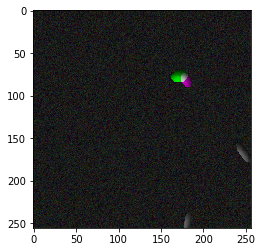

In [139]:
coln=colored_neurons(clumping_bool=True)
plt.imshow(coln)


In [140]:
directory = data_path + 'Neuron_Col_Live/Synthetic/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
for i in range(number_images):
    name=directory+str(i).zfill(5)+'.png'
    image=colored_neurons()
    io.imsave(name,image)
    if i%50==0:
        print i,

0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350